In [34]:
import pandas as pd
import pickle
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

### Read data

In [2]:
recs_1 = pd.read_csv("../data/recommendations/recommendations_strat_1_clean.csv").drop("Unnamed: 0", axis=1)
recs_2 = pd.read_csv("../data/recommendations/recommendations_strat_2_clean.csv").drop("Unnamed: 0", axis=1)
recs_3 = pd.read_csv("../data/recommendations/recommendations_strat_3_clean_temp.csv").drop("Unnamed: 0", axis=1)
recs_4 = pd.read_csv("../data/recommendations/recommendations_strat_4_clean_temp.csv").drop("Unnamed: 0", axis=1).dropna()

In [3]:
equal = pd.read_csv("../data/training_videos.csv").drop("Unnamed: 0", axis = 1)
equal["full_text"].fillna("", inplace=True)

### Vectorize 

In [4]:
# Vectorize words
v = TfidfVectorizer(max_df=.75, min_df=2)
x = v.fit_transform(equal['full_text'])

In [5]:
X = x
Y = equal['conspiracy'].values.ravel()

### Train or load model

In [6]:
try:
    svm = pickle.load(open('SVM_trained.sav', 'rb'))
except:
    # Train
    svm = SVC(C=10, kernel="rbf", max_iter = 10000).fit(X, Y)

    # save the model to disk
    pickle.dump(svm, open('SVM_trained.sav', 'wb'))

In [18]:
pickle.dump(mlp, open('MLP_trained.sav', 'wb'))

### Transform recommendations to tf-idf

In [7]:
recs_tfidf_1 = v.transform(recs_1["full_text"].values)
recs_tfidf_2 = v.transform(recs_2["full_text"].values)
recs_tfidf_3 = v.transform(recs_3["full_text"].values)
recs_tfidf_4 = v.transform(recs_4["full_text"].values)

### Predictions

In [8]:
predictions_1 = svm.predict(recs_tfidf_1)
predictions_2 = svm.predict(recs_tfidf_2)
predictions_3 = svm.predict(recs_tfidf_3)
predictions_4 = svm.predict(recs_tfidf_4)

In [9]:
predictions_1.mean(), predictions_2.mean(), predictions_3.mean(), predictions_4.mean()

(0.06619718309859154, 0.25069444444444444, 0.1, 0.09664948453608248)

In [136]:
recs_1["conspiracy_pred"] = predictions_1
recs_2["conspiracy_pred"] = predictions_2
recs_3["conspiracy_pred"] = predictions_3
recs_4["conspiracy_pred"] = predictions_4

## Aggregates

In [137]:
# Select useful columns
recs_1_sel = recs_1[["vids_watched", "views", "likes", "dislikes", "duration", "conspiracy_pred"]].copy()
recs_2_sel = recs_2[["vids_watched", "views", "likes", "dislikes", "duration", "conspiracy_pred"]].copy()
recs_3_sel = recs_3[["vids_watched", "views", "likes", "dislikes", "duration", "conspiracy_pred"]].copy()
recs_4_sel = recs_4[["vids_watched", "views", "likes", "dislikes", "duration", "conspiracy_pred"]].copy()

In [138]:
def to_seconds(duration):
    times = re.findall("\d+", duration)[::-1]
    return sum([int(times[i]) * 60**i for i in range(len(times))])

In [139]:
# Convert time to seconds
recs_1_sel["duration"] = recs_1_sel["duration"].apply(lambda x: to_seconds(str(x)))
recs_2_sel["duration"] = recs_2_sel["duration"].apply(lambda x: to_seconds(str(x)))
recs_3_sel["duration"] = recs_3_sel["duration"].apply(lambda x: to_seconds(str(x)))
recs_4_sel["duration"] = recs_4_sel["duration"].apply(lambda x: to_seconds(str(x)))

In [140]:
# Group
agg_1 = recs_1_sel.groupby("vids_watched")
agg_2 = recs_2_sel.groupby("vids_watched")
agg_3 = recs_3_sel.groupby("vids_watched")
agg_4 = recs_4_sel.groupby("vids_watched")

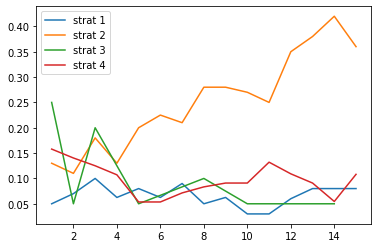

In [141]:
# plot
plt.plot(agg_1[["conspiracy_pred"]].mean(), label="strat 1")
plt.plot(agg_2[["conspiracy_pred"]].mean(), label="strat 2")
plt.plot(agg_3[["conspiracy_pred"]].mean(), label="strat 3")
plt.plot(agg_4[["conspiracy_pred"]].mean(), label="strat 4")

plt.legend(loc="upper left")
plt.show()

## Possible new strategy

In [38]:
# This is the video we're watching
test = recs_1.iloc[95]

In [140]:
# These are its recommendations
spoof = recs.iloc[100:120]

In [141]:
# Now, find to which recommendations the current video is closest
v2 = TfidfVectorizer()
s = v2.fit_transform(spoof["full_text"].values)

In [137]:
knn = NearestNeighbors(n_neighbors=1, metric='cosine')
knn.fit(s)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                 radius=1.0)

In [138]:
trans = v2.transform([test["full_text"]])

knn.kneighbors(trans, n_neighbors=1)

(array([[0.87229614]]), array([[19]], dtype=int64))